# Percolation Test

### Import Libraries

In [8]:
import matplotlib.pyplot as plt
import cmcrameri
import h5py
import numpy as np
from scipy import ndimage
import seaborn as sns
import pandas as pd
from cmcrameri import cm
import natsort

import sys
sys.path.append('./..')
from src.utils import get_cluster_labels, get_ds_iters
from src.training_utils import extract_floats

np.set_printoptions(precision=5)

2024-04-11 13:23:37.221633: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 13:23:37.255613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 13:23:37.701060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Define Auxiliary Functions

In [2]:
def get_biggest_cluster_loc(file, idx):
    kernel = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    labelled, _ = get_cluster_labels(file, idx)
    lb = labelled.flatten()
    cluster_sizes = np.bincount(lb)[1:]
    biggest_cluster_id = np.argmax(cluster_sizes) + 1
    return np.where(labelled == biggest_cluster_id)


def check_threshold(locs, threshold=20, dim=128):
    #print(np.ptp(locs[0]), np.ptp(locs[1]))
    if np.ptp(locs[0]) >= 128-threshold:
        return True
    if np.ptp(locs[1]) >= 128-threshold:
        return True
    return False

### Establish Percolation Values
NOTE: this program is set to append, so it will pile on the same data if this notebook is reran.

In [50]:
tumbles = np.logspace(-6,-1,10,base=2)
densities = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
files = []

for tumble in tumbles:
    for density in densities:
        files.append(f"../data/no-rolling/dataset_tumble_{tumble:.3f}_density_{density}.h5")

for ctr,file in enumerate(files):
    with h5py.File(file, "r") as fin:
        key_list = list(fin.keys())
        iter_n = get_ds_iters(key_list)
        percolating = 0
        total = 0
        for idx in range(50,1000): #amount of snapshots we have in the data sets
            locs = get_biggest_cluster_loc(file,idx)
            percolating += check_threshold(locs)
            total+=1
    ratio = float(percolating) / float(total)
    values = extract_floats(file)
    output_line = f"{values[0]} {values[1]} {ratio}\n"
    with open("cache/percolation.txt", "a") as cache:
        cache.write(output_line)
        print(output_line,end='')
        


0.016 0.45 0.8463157894736842
0.023 0.45 0.8010526315789473
0.034 0.45 0.651578947368421
0.050 0.45 0.5063157894736842
0.073 0.45 0.4231578947368421
0.107 0.45 0.4189473684210526
0.157 0.45 0.32105263157894737
0.231 0.45 0.3105263157894737
0.340 0.45 0.24210526315789474
0.500 0.45 0.16631578947368422


### Read Percolations

In [54]:
with open("cache/percolation.txt", 'r') as cache:
    res = cache.readlines()
    perc = []
    for val in res:
        line_list = [float(i) for i in val.split(" ")]
        perc.append(line_list[2])
        if line_list[2] > 0.75: #frequency threshold for percolating condition is 75%
            print(f"tumble {line_list[0]}, dens {line_list[1]} undergoes percolation")
    #perc = [float(val.strip('\n')) for val in res[2]]
    perc = np.reshape(perc, (10,10))

tumble 0.016, dens 0.45 undergoes percolation
tumble 0.016, dens 0.5 undergoes percolation
tumble 0.023, dens 0.45 undergoes percolation
tumble 0.023, dens 0.5 undergoes percolation
tumble 0.034, dens 0.5 undergoes percolation
tumble 0.05, dens 0.5 undergoes percolation
tumble 0.073, dens 0.5 undergoes percolation


### Plot Results

/tmp/ipykernel_9498/2130497943.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(xlabels,3)[::2])
/tmp/ipykernel_9498/2130497943.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.round(ylabels,3)[::2])


Text(8.75, 3, 'Percolating')

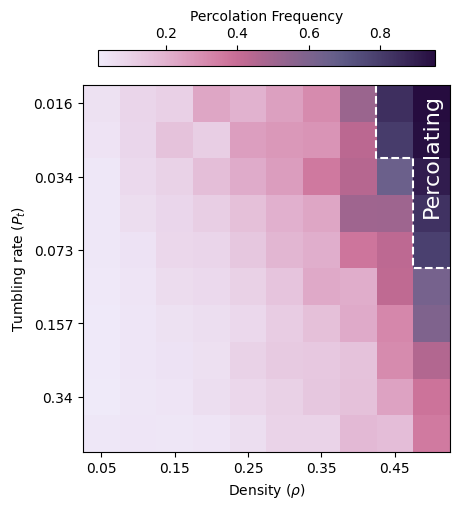

In [69]:
tumbles = np.logspace(-6,-1,10, base=2)
density = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

cmap = plt.get_cmap('cmc.acton')

xlabels = np.concatenate(([0,0],tumbles))
ylabels = np.concatenate(([0,0],density))

fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
m = ax.imshow(perc, cmap=cmap.reversed())
cbar = plt.colorbar(ax=ax, mappable=m, location='top', aspect=20, fraction=0.046, pad=0.05)
ax.set_yticklabels(np.round(xlabels,3)[::2])
ax.set_xticklabels(np.round(ylabels,3)[::2])

ax.plot([7.5,7.5,8.5,8.5,9.5],[-0.5,1.5,1.5,4.5,4.5], c='white', linestyle='--')

cbar.ax.set_xlabel('Percolation Frequency')

ax.set_ylabel(r"Tumbling rate ($P_t$)")
ax.set_xlabel(r"Density ($\rho$)")

ax.text(s="Percolating", x=8.75, y=3, c='w', rotation=90, fontsize=16)